In [1]:
import os
os.chdir("../")

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import Counter
from src.functions import train, train_models, select_best_model, evaluate_performance
from src.models import DetectNet1_2x3, DetectNet2_2x3
from src.DataAnalysis import DataAnalysis
from src.object_detection import get_converted_data

In [3]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {DEVICE}")

Using device: cuda


## Data exploration

In [4]:
grid_dimensions = (2,3)

In [5]:
object_train, object_val, object_test = get_converted_data(grid_dimensions=grid_dimensions) 

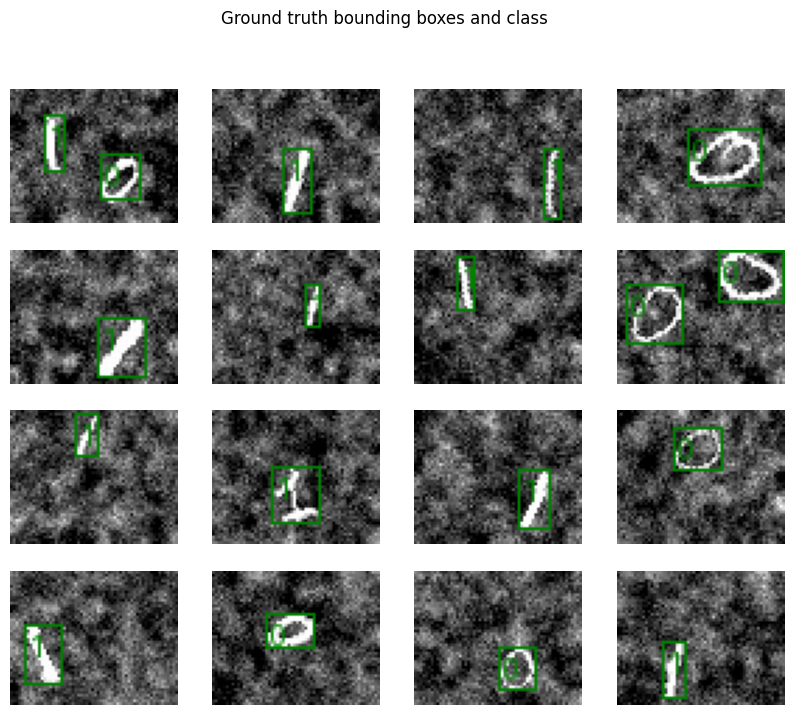

In [6]:
DataAnalysis.plot_detection_instances(object_train, (4,4), grid_dimensions=grid_dimensions, 
                                      title="Ground truth bounding boxes and class", save_to_file="imgs/detection/true.png")

## Training

In [7]:
# Normalize from training data
imgs = torch.stack([img for img, _ in object_train])

# Define normalizer
normalizer = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

object_train_norm = [(normalizer(img), label) for img, label in object_train]
object_val_norm = [(normalizer(img), label) for img, label in object_val]
object_test_norm = [(normalizer(img), label) for img, label in object_test]

In [8]:
batch_size = 64
torch.manual_seed(SEED)
train_loader = DataLoader(object_train_norm, batch_size=batch_size, shuffle=True)
torch.manual_seed(SEED)
val_loader = DataLoader(object_val_norm, batch_size=batch_size, shuffle=True)

In [9]:
epochs = 50
early_stop_patience = 7
networks = [DetectNet1_2x3, DetectNet2_2x3]

hyper_parameters = [
    {"lr": 0.001, "weight_decay": 0.0001, "momentum": 0.2},
    {"lr": 0.001, "weight_decay": 0.0005, "momentum": 0.1},
    {"lr": 0.005, "weight_decay": 0.0, "momentum": 0.3},
    {"lr": 0.005, "weight_decay": 0.0001, "momentum": 0.1},
]

In [10]:
results = train_models(
    "detection",
    networks,
    hyper_parameters,
    batch_size,
    epochs,
    train_loader,
    val_loader,
    DEVICE,
    SEED,
    early_stop_patience
)

	Global parameters:
Batch size: 64
Epochs: 50
Seed: 265

Model architecture: <class 'code_base.models.DetectNet1_2x3'>

	Current parameters: 
lr:0.001
weight_decay:0.0001
momentum:0.2
Starting training for detection using above parameters:


| 14:41:39.909763 | Epoch: 1 | train_loss: 4.086 | val_loss: 3.611 | train strict accuracy: 0.000% | val Strict accuracy: 0.000% |

| 14:44:34.292425 | Epoch: 10 | train_loss: 2.299 | val_loss: 2.236 | train strict accuracy: 0.056% | val Strict accuracy: 0.060% |
__Stopping training in 6 epochs
__Patience reset

| 14:48:13.821100 | Epoch: 20 | train_loss: 1.933 | val_loss: 1.858 | train strict accuracy: 0.142% | val Strict accuracy: 0.427% |
__Stopping training in 6 epochs
__Patience reset
__Stopping training in 6 epochs
__Patience reset
__Stopping training in 6 epochs
__Stopping training in 5 epochs

| 14:52:06.312274 | Epoch: 30 | train_loss: 1.738 | val_loss: 1.663 | train strict accuracy: 0.533% | val Strict accuracy: 0.458% |
__Patience reset


In [11]:
best_model, best_model_idx = select_best_model(results["models"], results["strict_val"])
print(best_model)

DetectNet2_2x3(
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(8, 6, kernel_size=(3, 3), stride=(1, 1))
)


In [12]:
bm_hyper_params = results["hyper_params"][best_model_idx]
bm_train_loss = results["loss_train"][best_model_idx]
bm_val_loss = results["loss_val"][best_model_idx]
best_model_train_performance = results["strict_train"][best_model_idx]
best_model_val_performance = results["strict_val"][best_model_idx]

Selected hyper parameters
{'lr': 0.005, 'weight_decay': 0.0001, 'momentum': 0.1}


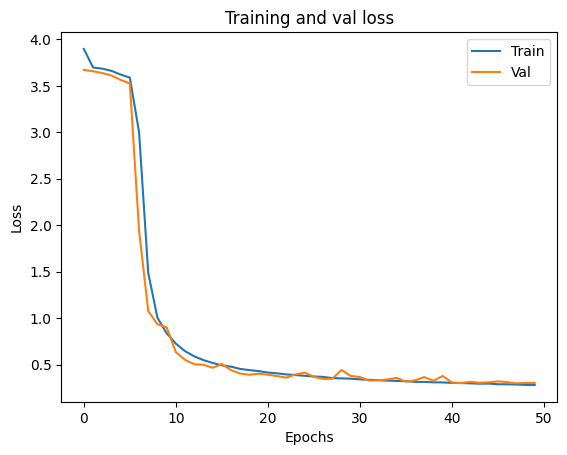

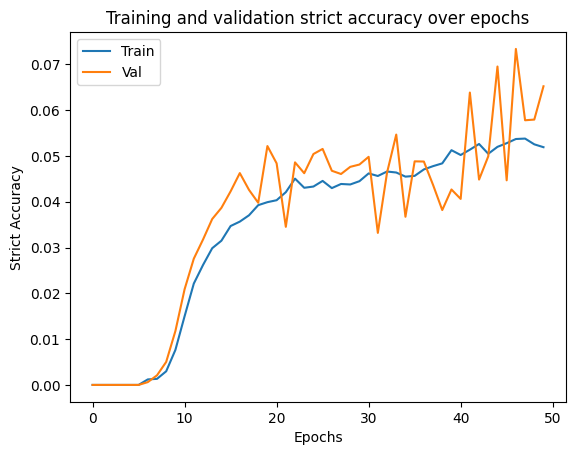

In [13]:
# Hyper parameters
print("Selected hyper parameters")
print(bm_hyper_params)

# Loss
DataAnalysis.plot_performance_over_time(bm_train_loss, bm_val_loss, "Training and val loss", y_label="Loss",
                                       save_to_file="imgs/detection/loss.png")

# Strict accuracy
DataAnalysis.plot_performance_over_time(best_model_train_performance, best_model_val_performance, "Training and validation strict accuracy over epochs", 
                                        y_label="Strict Accuracy", save_to_file="imgs/detection/strict.png")

## Evaluation

In [14]:
torch.manual_seed(SEED)
test_loader = DataLoader(object_test_norm, batch_size=batch_size, shuffle=True)

perf, output = evaluate_performance("detection", best_model, test_loader, device=DEVICE)
print(f"--- Test performance ---")
print(f"Strict accuracy: {perf['strict']*100:.2f}%")

--- Test performance ---
Strict accuracy: 6.19%


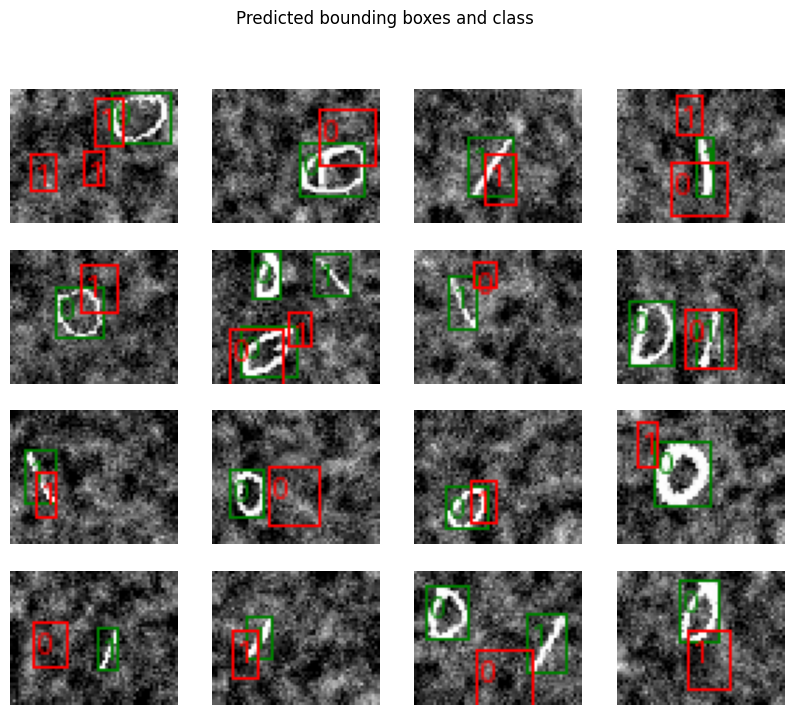

In [15]:
DataAnalysis.plot_detection_instances(object_test, (4,4), predictions=output, grid_dimensions=grid_dimensions,
                                      title="Predicted bounding boxes and class", save_to_file="imgs/detection/pred.png")